# Minimizing Portfolio Variance (2023.07-2024.07)

## 1. Helper Functions

In [1]:
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

stocks = ['MSFT', 'ORCL', 'ADBE', 'AAPL', 'INTC', 'AMZN', 'META', 'T', 'ERIC', 'NOK', 'IBM', 'ACN', 'TCS.NS', 'NVDA', 'QCOM', 'TXN', 'TSLA', 'PLTR']

def fetch_data(stocks, start_date, end_date):
    return yf.download(stocks, start=start_date, end=end_date)['Adj Close']

def process_data(stocks, start_date, end_date):
    stock_data = fetch_data(stocks, start_date, end_date)
    returns = stock_data.pct_change().dropna()
    scaled_returns = StandardScaler().fit_transform(returns)
    Sigma_hat = np.cov(scaled_returns.T)
    Sigma_hat_tensor = torch.tensor(Sigma_hat, dtype=torch.float32)
    return Sigma_hat, Sigma_hat_tensor

def calculate_weights(Sigma_hat, allow_short=False):
    m = Sigma_hat.shape[0]
    w = cp.Variable(m)
    portfolio_variance = cp.quad_form(w, Sigma_hat)
    constraints = [cp.sum(w) == 1]
    if not allow_short:
        constraints.append(w >= 0)
    cp.Problem(cp.Minimize(portfolio_variance), constraints).solve()
    return w.value

class PortfolioOptimization(nn.Module):
    def __init__(self, m):
        super(PortfolioOptimization, self).__init__()
        self.weights = nn.Parameter(torch.full((m,), 1/m, requires_grad=True))
        
    def forward(self):
        return self.weights

def loss_func(weights, Sigma):
    return weights @ Sigma @ weights

def train(loss_func, m, Sigma, lr, num_epochs=100000, allow_short=True):
    model = PortfolioOptimization(m)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        weights = model()
        if not allow_short:
            weights = torch.relu(weights)
        weights = weights / torch.sum(weights) 
        loss = loss_func(weights, torch.tensor(Sigma, dtype=torch.float32))
        loss.backward()
        optimizer.step()
    return weights.detach().numpy()

def rebalance_portfolio(current_portfolio, target_weights, start_prices):
    current_value = sum(current_portfolio[stock] * start_prices[stock] for stock in current_portfolio)
    adjustments = {}
    for stock, target_weight in target_weights.items():
        target_value = target_weight * current_value
        current_value_stock = current_portfolio[stock] * start_prices[stock]
        delta_value = target_value - current_value_stock
        adjustments[stock] = delta_value / start_prices[stock]
    for stock in current_portfolio:
        current_portfolio[stock] += adjustments[stock]
    return current_portfolio

## 2. No Rebalancing

### 2.1. Allow Short Selling

In [2]:
start_date = "2023-06-01"
end_date = "2023-06-30"
buy_date = "2023-07-01"
sell_date = "2024-06-30"

Sigma_hat, Sigma_hat_tensor = process_data(stocks, start_date, end_date)
optimal_weights_theoretical = calculate_weights(Sigma_hat, allow_short=True)
optimal_weights_training = train(loss_func, m=len(stocks), Sigma=Sigma_hat, lr=0.1, num_epochs=100000, allow_short=True)

ws_dict = {"Stocks": stocks}
ws_dict["Theoretical"] = optimal_weights_theoretical
ws_dict["Trained"] = optimal_weights_training
combine = pd.DataFrame(ws_dict)

portfolio_data = fetch_data(combine['Stocks'].tolist(), buy_date, sell_date).ffill()
start_prices = portfolio_data.dropna().iloc[0] 
end_prices = portfolio_data.dropna().iloc[-1]
initial_budget = 10000
weights = combine['Trained'].tolist()

initial_total_shares_value = 0
shares_to_buy = {}
for stock, weight in zip(stocks, weights):
    price_per_share = start_prices[stock]
    num_shares = (initial_budget * weight * 0.98) / price_per_share
    shares_to_buy[stock] = num_shares
    initial_total_shares_value += num_shares * price_per_share
fees_to_buy = 0.02 * initial_total_shares_value
total_remaining_cash = initial_budget - initial_total_shares_value - fees_to_buy

final_total_shares_value = 0
for stock, num_shares in shares_to_buy.items():
    price_per_share = end_prices[stock]
    final_total_shares_value += num_shares * price_per_share
fees_to_sell = 0.02 * final_total_shares_value
gain = final_total_shares_value - initial_total_shares_value
tax = 0.015 * gain
net_return = final_total_shares_value - initial_total_shares_value - fees_to_sell - tax
dollar_return = net_return + total_remaining_cash
percent_return = dollar_return / initial_budget * 100

print(f"Avg Monthly Percentage Return: {percent_return/12:.2f}%")

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed

Avg Monthly Percentage Return: 2.26%


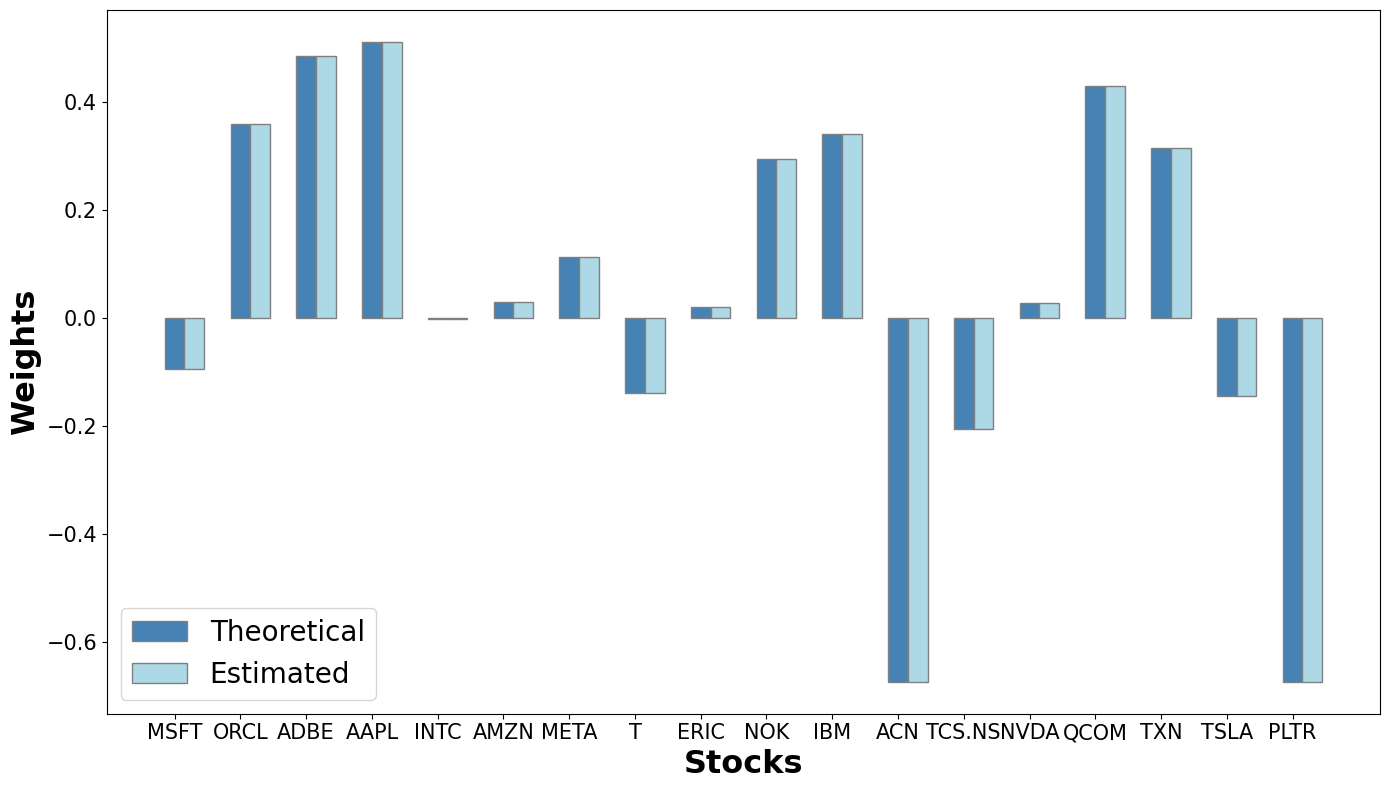

In [3]:
plt.figure(figsize=(14, 8))
barWidth = 0.3
positions = np.arange(len(combine))
plt.bar(positions, combine['Theoretical'], color='steelblue', width=barWidth, edgecolor='grey', label='Theoretical')
plt.bar(positions+barWidth, combine['Trained'], color='lightblue', width=barWidth, edgecolor='grey', label='Estimated')
plt.xlabel('Stocks', fontweight='bold', size=23)
plt.ylabel('Weights', fontweight='bold', size=23)
plt.xticks(positions, combine['Stocks'], size=15)
plt.yticks(size=15)
plt.legend(loc='lower left', fontsize=20)
plt.tight_layout()
plt.show()

### 2.2. No Short Selling

In [4]:
Sigma_hat, Sigma_hat_tensor = process_data(stocks, start_date, end_date)
optimal_weights_theoretical = calculate_weights(Sigma_hat, allow_short=False)
optimal_weights_training = train(loss_func, m=len(stocks), Sigma=Sigma_hat, lr=0.1, num_epochs=100000, allow_short=False)

ws_dict = {"Stocks": stocks}
ws_dict["Theoretical"] = optimal_weights_theoretical
ws_dict["Trained"] = optimal_weights_training
combine = pd.DataFrame(ws_dict)

portfolio_data = fetch_data(combine['Stocks'].tolist(), buy_date, sell_date).ffill()
start_prices = portfolio_data.dropna().iloc[0] 
end_prices = portfolio_data.dropna().iloc[-1]
initial_budget = 10000
weights = combine['Trained'].tolist()

initial_total_shares_value = 0
shares_to_buy = {}
for stock, weight in zip(stocks, weights):
    price_per_share = start_prices[stock]
    num_shares = (initial_budget * weight * 0.98) / price_per_share
    shares_to_buy[stock] = num_shares
    initial_total_shares_value += num_shares * price_per_share
fees_to_buy = 0.02 * initial_total_shares_value
total_remaining_cash = initial_budget - initial_total_shares_value - fees_to_buy

final_total_shares_value = 0
for stock, num_shares in shares_to_buy.items():
    price_per_share = end_prices[stock]
    final_total_shares_value += num_shares * price_per_share
fees_to_sell = 0.02 * final_total_shares_value
gain = final_total_shares_value - initial_total_shares_value
tax = 0.015 * gain
net_return = final_total_shares_value - initial_total_shares_value - fees_to_sell - tax
dollar_return = net_return + total_remaining_cash
percent_return = dollar_return / initial_budget * 100

print(f"Avg Monthly Percentage Return: {percent_return/12:.2f}%")

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed

Avg Monthly Percentage Return: 1.99%


## 3. No Rebalancing

### 3.1. Allow Short Selling

In [5]:
date_ranges = [
    ("2023-06-01", "2023-06-30", "2023-07-01", "2023-07-31"),
    ("2023-07-01", "2023-07-31", "2023-08-01", "2023-08-31"),
    ("2023-08-01", "2023-08-31", "2023-09-01", "2023-09-30"),
    ("2023-09-01", "2023-09-30", "2023-10-01", "2023-10-31"),
    ("2023-10-01", "2023-10-31", "2023-11-01", "2023-11-30"),
    ("2023-11-01", "2023-11-30", "2023-12-01", "2023-12-31"),
    ("2023-12-01", "2023-12-31", "2024-01-01", "2024-01-31"),
    ("2024-01-01", "2024-01-31", "2024-02-01", "2024-02-29"),
    ("2024-02-01", "2024-02-29", "2024-03-01", "2024-03-31"),
    ("2024-03-01", "2024-03-31", "2024-04-01", "2024-04-30"),
    ("2024-04-01", "2024-04-30", "2024-05-01", "2024-05-31"),
    ("2024-05-01", "2024-05-31", "2024-06-01", "2024-06-30")]

reweights_dict = {"Stocks": stocks}
theoretical_weights = []
portfolio_data_list = []

for i, (start_date, end_date, buy_date, sell_date) in enumerate(date_ranges):
    Sigma_hat, Sigma_hat_tensor = process_data(stocks, start_date, end_date)
    theoretical_w = calculate_weights(Sigma_hat, allow_short=True)
    theoretical_weights.append(theoretical_w)
    estimated_weights = train(loss_func, m=len(stocks), Sigma=Sigma_hat, lr=0.5, num_epochs=100000, allow_short=True)
    reweights_dict[f"Theoretical{i+1}"] = theoretical_w
    reweights_dict[f"Estimated{i+1}"] = estimated_weights
    portfolio_data = fetch_data(stocks, buy_date, sell_date).ffill()
    portfolio_data_list.append(portfolio_data)
reweights_table = pd.DataFrame(reweights_dict)
reweights_table.set_index('Stocks', inplace=True)
portfolio_data = {f"portfolio_data{i+1}": data for i, data in enumerate(portfolio_data_list)}
start_prices_list = [portfolio_data[f"portfolio_data{i}"].dropna().iloc[0] for i in range(1, 13)]
end_prices_list = [portfolio_data[f"portfolio_data{i}"].dropna().iloc[-1] for i in range(1, 13)]

initial_budget = 10000
initial_portfolio = {stock: (initial_budget / len(stocks)) / start_prices_list[0][stock] for stock in stocks}
portfolio_values = [initial_budget]
fees_to_buy_total = 0
fees_to_sell_total = 0
tax_total = 0

for i in range(12):
    start_prices = start_prices_list[i]
    end_prices = end_prices_list[i]
    target_weights = reweights_table[f"Estimated{i+1}"].to_dict()
    current_portfolio = rebalance_portfolio(initial_portfolio, target_weights, start_prices)
    portfolio_value = sum(current_portfolio[stock] * end_prices[stock] for stock in current_portfolio)
    fees_to_buy = 0.02 * portfolio_value
    fees_to_sell = 0.02 * portfolio_value
    gain = portfolio_value - initial_budget
    tax = 0.015 * gain
    fees_to_buy_total += fees_to_buy
    fees_to_sell_total += fees_to_sell
    tax_total += tax
    net_portfolio_value = portfolio_value - fees_to_buy - fees_to_sell - tax
    portfolio_values.append(net_portfolio_value)
    initial_portfolio = current_portfolio
final_portfolio_value = portfolio_values[-1]
dollar_return = final_portfolio_value - initial_budget
percent_return = dollar_return / initial_budget * 100

print(f"Avg Monthly Percentage Return: {percent_return/12:.2f}%")

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*****

Avg Monthly Percentage Return: 4.33%


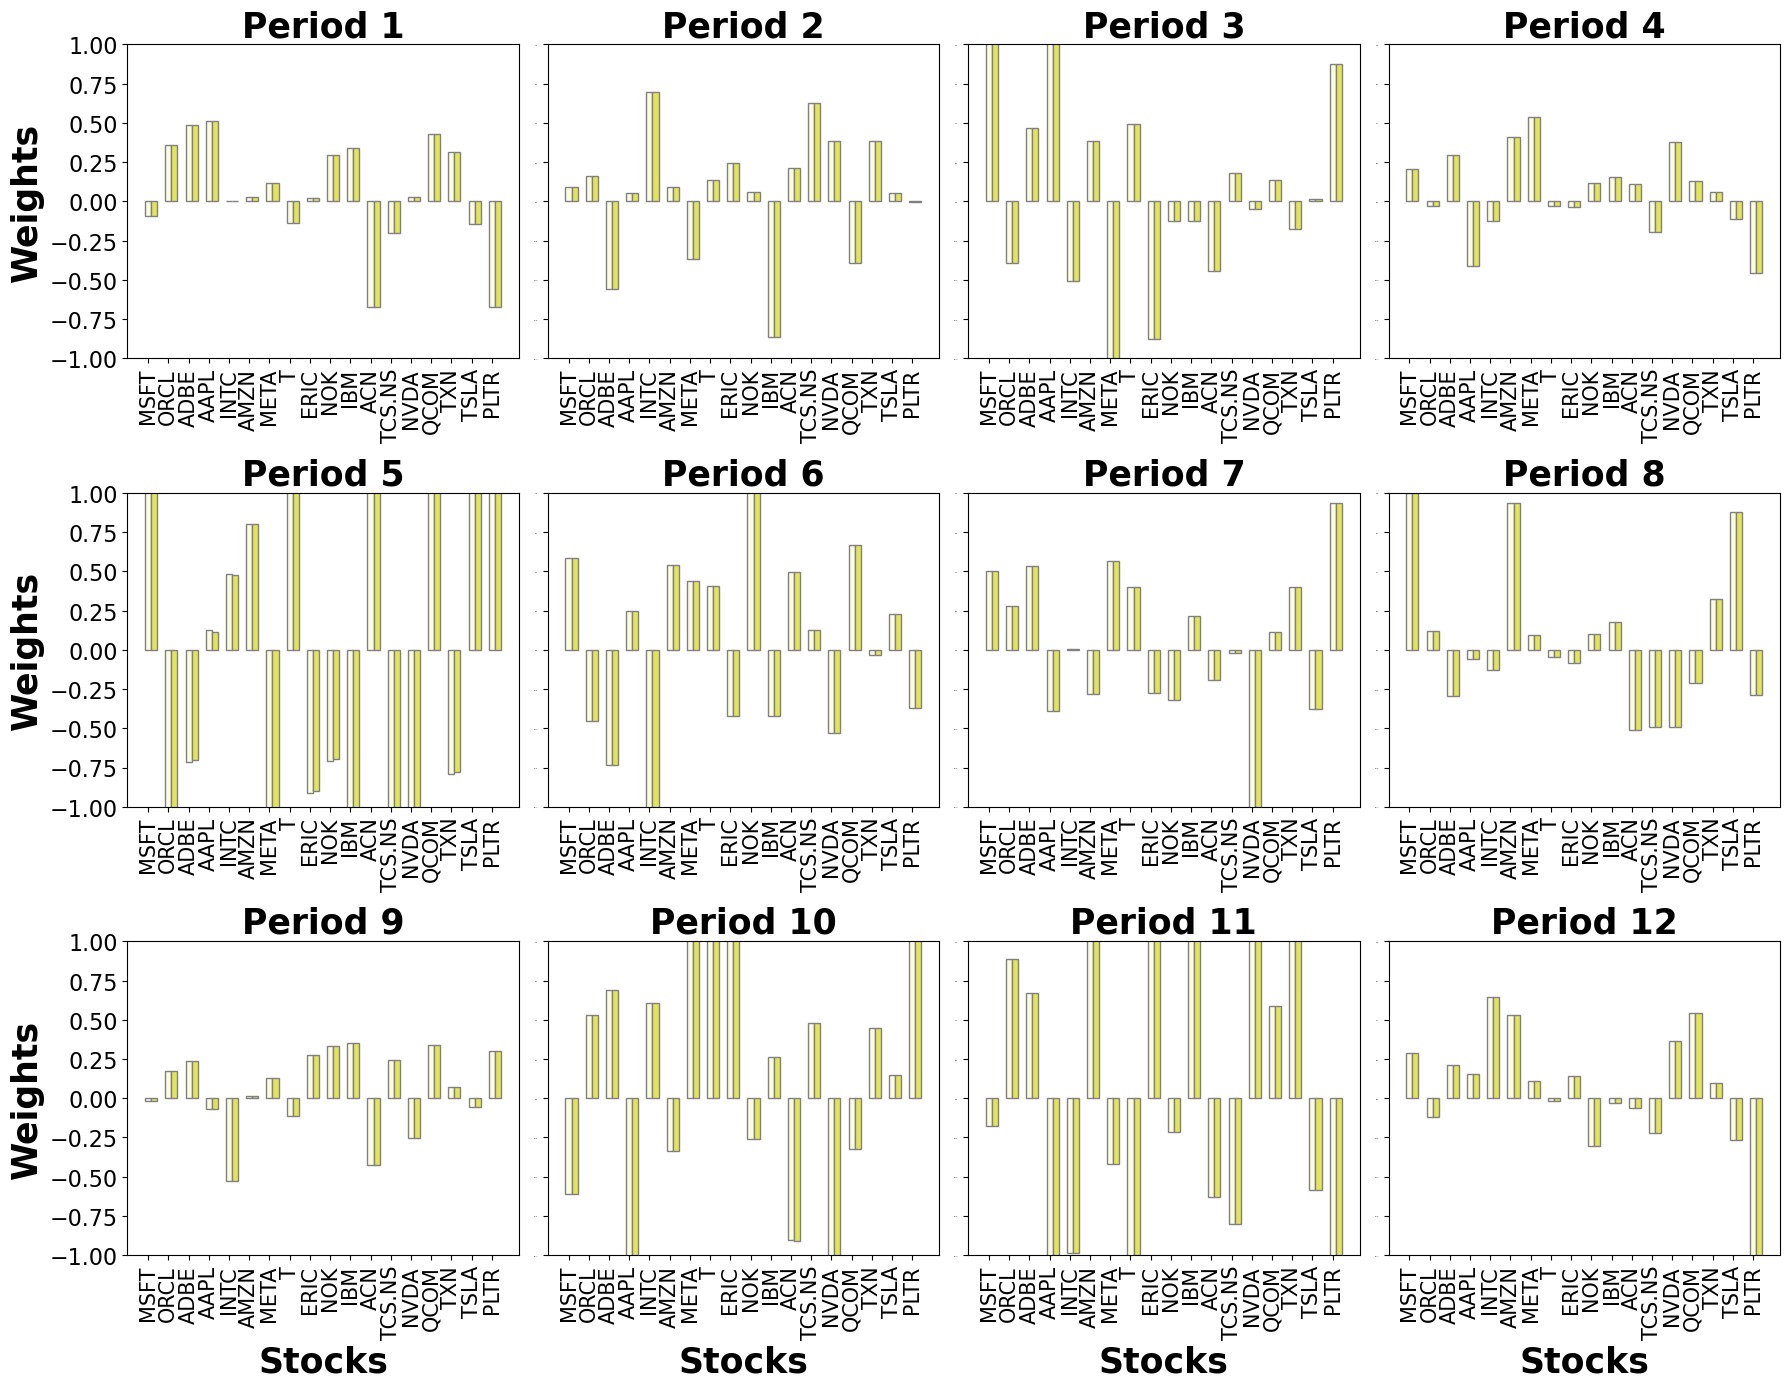

In [6]:
plt.figure(figsize=(20, 14))
barWidth = 0.3
positions = np.arange(len(reweights_table))
for i in range(1, 13):
    plt.subplot(3, 4, i)
    plt.bar(positions, reweights_table[f'Theoretical{i}'], color='#FCFCE3', width=barWidth, edgecolor='grey', label='Theoretical')
    plt.bar(positions + barWidth, reweights_table[f'Estimated{i}'], color='#E3E457', width=barWidth, edgecolor='grey', label='Estimated')
    if i in [1, 5, 9]:
        plt.ylabel('Weights', fontweight='bold', size=25)
    if i in [9, 10, 11, 12]:
        plt.xlabel('Stocks', fontweight='bold', size=25)
    plt.xticks(positions, reweights_table.index, rotation=90, size=15)
    plt.yticks(size=16 if i in [1, 5, 9] else 0)
    plt.ylim(-1.0,1.0)
    plt.title(f'Period {i}', fontweight='bold', size=25)
plt.tight_layout(rect=[0, 0, 0.9, 1])
# plt.figlegend(['Theoretical', 'Estimated'], loc='center right', fontsize=25, bbox_to_anchor=(1.065, 0.945))
plt.show()

### 3.2. No Short Selling

In [7]:
reweights_dict = {"Stocks": stocks}
theoretical_weights = []
portfolio_data_list = []

for i, (start_date, end_date, buy_date, sell_date) in enumerate(date_ranges):
    Sigma_hat, Sigma_hat_tensor = process_data(stocks, start_date, end_date)
    theoretical_w = calculate_weights(Sigma_hat, allow_short=False)
    theoretical_weights.append(theoretical_w)
    estimated_weights = train(loss_func, m=len(stocks), Sigma=Sigma_hat, lr=0.1, num_epochs=100000, allow_short=False)
    reweights_dict[f"Theoretical{i+1}"] = theoretical_w
    reweights_dict[f"Estimated{i+1}"] = estimated_weights
    portfolio_data = fetch_data(stocks, buy_date, sell_date).ffill()
    portfolio_data_list.append(portfolio_data)
reweights_table = pd.DataFrame(reweights_dict)
reweights_table.set_index('Stocks', inplace=True)
portfolio_data = {f"portfolio_data{i+1}": data for i, data in enumerate(portfolio_data_list)}
start_prices_list = [portfolio_data[f"portfolio_data{i}"].dropna().iloc[0] for i in range(1, 13)]
end_prices_list = [portfolio_data[f"portfolio_data{i}"].dropna().iloc[-1] for i in range(1, 13)]

initial_budget = 10000
initial_portfolio = {stock: (initial_budget / len(stocks)) / start_prices_list[0][stock] for stock in stocks}
portfolio_values = [initial_budget]
fees_to_buy_total = 0
fees_to_sell_total = 0
tax_total = 0

for i in range(12):
    start_prices = start_prices_list[i]
    end_prices = end_prices_list[i]
    target_weights = reweights_table[f"Estimated{i+1}"].to_dict()
    current_portfolio = rebalance_portfolio(initial_portfolio, target_weights, start_prices)
    portfolio_value = sum(current_portfolio[stock] * end_prices[stock] for stock in current_portfolio)
    fees_to_buy = 0.02 * portfolio_value
    fees_to_sell = 0.02 * portfolio_value
    gain = portfolio_value - initial_budget
    tax = 0.015 * gain
    fees_to_buy_total += fees_to_buy
    fees_to_sell_total += fees_to_sell
    tax_total += tax
    net_portfolio_value = portfolio_value - fees_to_buy - fees_to_sell - tax
    portfolio_values.append(net_portfolio_value)
    initial_portfolio = current_portfolio
final_portfolio_value = portfolio_values[-1]
dollar_return = final_portfolio_value - initial_budget
percent_return = dollar_return / initial_budget * 100

print(f"Avg Monthly Percentage Return: {percent_return/12:.2f}%")

[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*********************100%%**********************]  18 of 18 completed
[*****

Avg Monthly Percentage Return: 1.71%
